Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Paths are specified according to my googledrive. Need to change if required
data_dir_train = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in Train:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images in Test:",image_count_test)

Number of images in Train: 2239
Number of images in Test: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [29]:
## Train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [30]:
## Validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

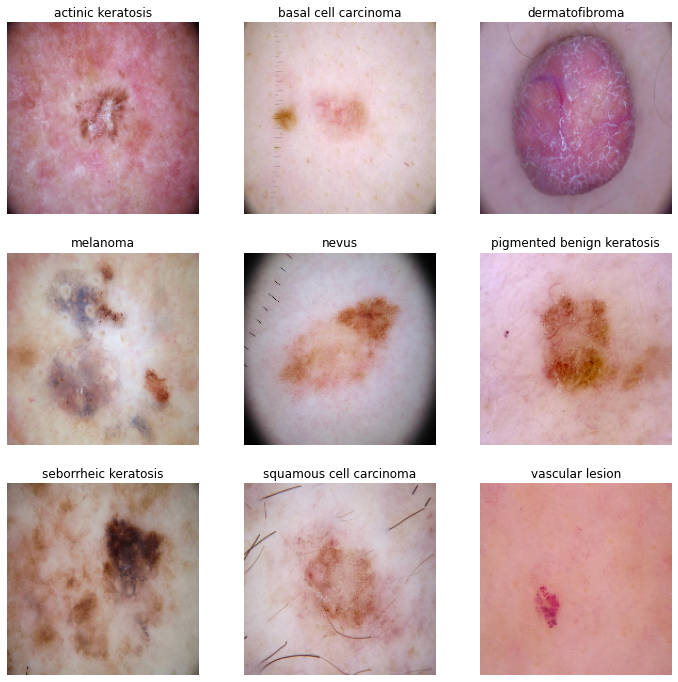

In [10]:
### Used training data to visualize all the nine classes in the dataset

plt.figure(figsize=(12, 12))

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
   

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Model1 : Base model

In [32]:
#Number of catgeories
num_classes = 9
model1 = Sequential()
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# keras convolutional layer is called Conv2D, note that the first layer needs to be told the input shape explicitly
# Adding four convolutions with pooling layers to reduce the size of the image
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#flatten and put a fully connected layer
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
# softmax layer
model1.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training.

Using Adam as optimizer function and SparseCategoricalCrossentropy for loss function as this is a multi class classification problem. Will use the same for all the models to compare the accuracies and loss among different models.

In [33]:
###choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [35]:
#Train the model for 20 epochs
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 81ms/step - loss: 2.0561 - accuracy: 0.2093 - val_loss: 2.0460 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.9824 - accuracy: 0.2388 - val_loss: 1.8352 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7580 - accuracy: 0.3583 - val_loss: 1.6139 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5924 - accuracy: 0.4208 - val_loss: 1.6064 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4590 - accuracy: 0.4816 - val_loss: 1.4328 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4342 - accuracy: 0.4844 - val_loss: 1.3898 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3871 - accuracy: 0.4933 - val_loss: 1.4098 - val_accuracy: 0.5123
Epoch 8/20
5

### Visualizing training results

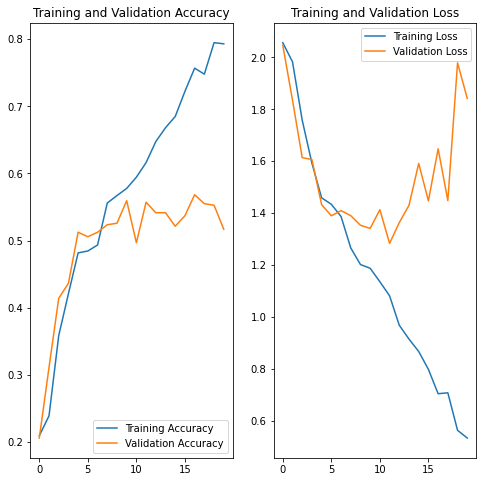

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit

From the above model we can clearly see there is an overfitting as there is a huge difference of accuracies between training data and validation data.

Similarly for loss, training loss getting decreased for each epoch where as validation loss goes up.


To resolve the overfitting, Use the data augmentation strategy and check whether this helps. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model.

In [16]:
# Data augumentation strategy. 
#Creating more datapoints/images for training using data augmentation techniques. Used RandomFlip,Rotation and Zoom
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                      layers.experimental.preprocessing.RandomRotation(0.2),
                                      layers.experimental.preprocessing.RandomZoom(0.2),
])

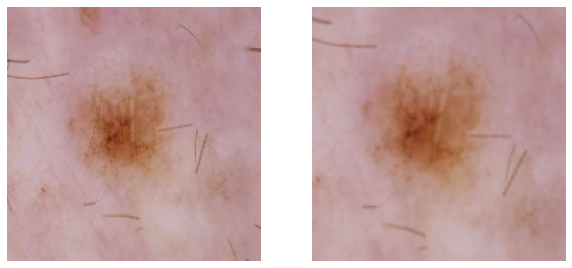

In [31]:
#  visualize how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    ax = plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

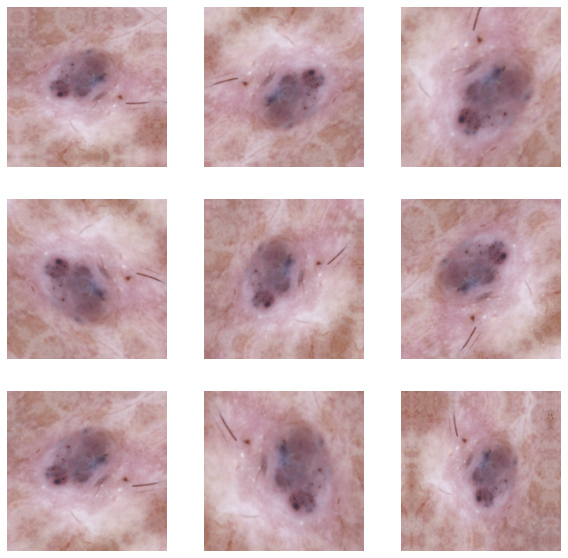

In [32]:
# visualize augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Create the model, compile and train the model


##### Model2 : Model with data augmentation and dropouts

In [17]:
## Used Dropout layer as there is an evidence of overfitting in above model

num_classes = 9
model2 = Sequential([ data_augmentation,
                   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
# keras convolutional layer is called Conv2D, note that the first layer needs to be told the input shape explicitly
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model2.add(MaxPooling2D(pool_size = (2, 2)))


model2.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

#flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
# softmax layer
model2.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [18]:
## Compiling the model. Using adam and SparseCategoricalCrossentropy as mentioned earlier
model2.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


### Training the model

In [19]:
## train the model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 4s 37ms/step - loss: 2.0185 - accuracy: 0.2305 - val_loss: 1.9054 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.8320 - accuracy: 0.3158 - val_loss: 1.7374 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7527 - accuracy: 0.3460 - val_loss: 1.6955 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6439 - accuracy: 0.4057 - val_loss: 1.5519 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5729 - accuracy: 0.4252 - val_loss: 1.5425 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4838 - accuracy: 0.4688 - val_loss: 1.5833 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5146 - accuracy: 0.4754 - val_loss: 1.4505 - val_accuracy: 0.4922
Epoch 8/20
56

### Visualizing the results

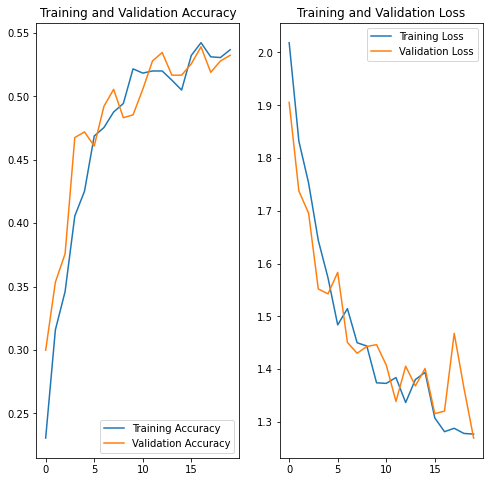

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

By applying Data augmentation and using dropouts there is an improvement related to overfitting as there is no much difference between the training accuracy and validation accuracy  when compared to previous model but overall training accuracy is very low due to which we can say that the model is kind of underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
## Get the list of classes and put them in a dataframe
df_cancertypes=[]
for classtype in class_names:
  class_list = [x for x in data_dir_train.glob(classtype+'/*.jpg')]
  df_cancertypes.append(len(class_list))
df_cancertypes = pd.DataFrame(list(zip(class_names,df_cancertypes)),columns=["Category","Count"])
print(df_cancertypes)


                     Category  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


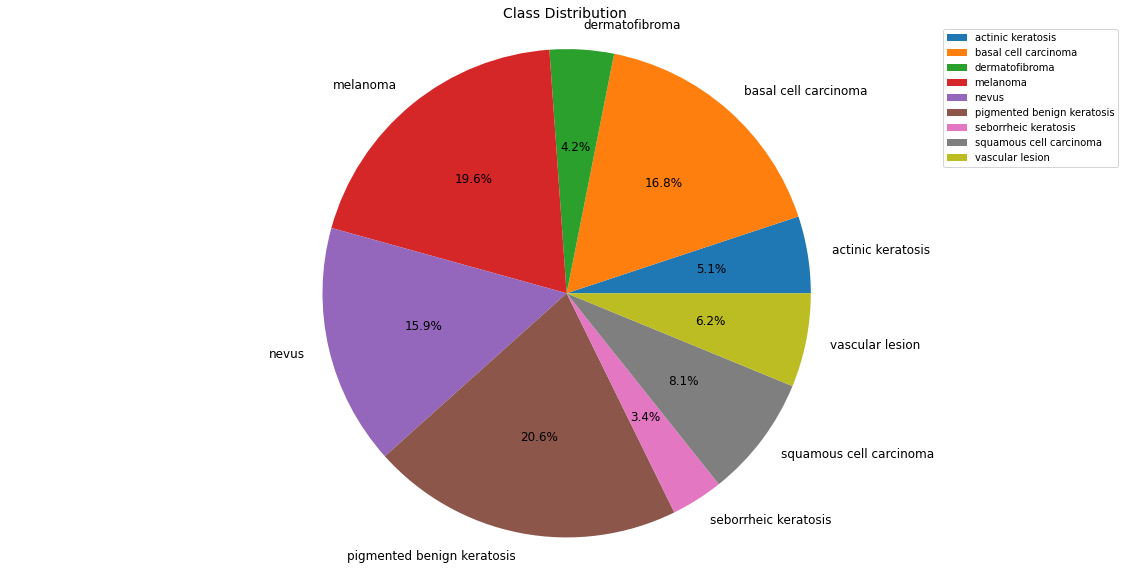

In [22]:
#Pie chart to review the class distribution
ax = (df_cancertypes["Count"]*100.0 /sum(df_cancertypes["Count"])).plot.pie(autopct='%.1f%%', labels = df_cancertypes["Category"],figsize =(20,10), fontsize = 12)                                                                           
ax.set_ylabel('',fontsize = 12)
ax.set_title('Class Distribution', fontsize = 14)
plt.legend(df_cancertypes["Category"])
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()


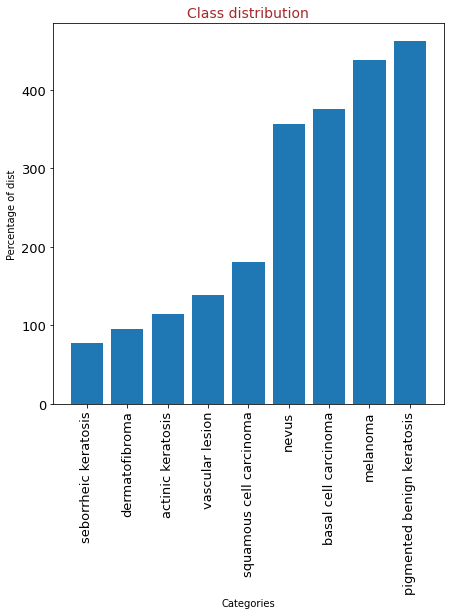

In [23]:
#Bar chart to review the classes
df_cancertypes.sort_values(by="Count",inplace=True)
plt.figure(figsize=(7,7))
plt.bar(x=df_cancertypes["Category"],height=df_cancertypes["Count"])
plt.yticks(fontsize=13)
plt.xlabel('Categories')
plt.ylabel('Percentage of dist')
plt.title('Class distribution',fontdict={'fontsize': 14, 'fontweight' : 5, 'color' : 'Brown'})
plt.xticks(fontsize = 13,rotation=90)
plt.show()

In [37]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("path_list: ",len(path_list))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(lesion_list))
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print(original_df.Label.value_counts())
original_df.head()

path_list:  2239
lesion_list:  2239
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


,Path,Label
0,/content/drive/My Drive/Colab Notebooks/CNN_As...,melanoma
1,/content/drive/My Drive/Colab Notebooks/CNN_As...,melanoma
2,/content/drive/My Drive/Colab Notebooks/CNN_As...,melanoma
3,/content/drive/My Drive/Colab Notebooks/CNN_As...,melanoma
4,/content/drive/My Drive/Colab Notebooks/CNN_As...,melanoma


#### Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has least number of samples in the data

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis(20.6%) followed by melanoma(19.6%) ,basal cell carcinoma(16.8%), nevus(15.9%) dominates the data.


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE78F7F90>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBAE6070610>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE7843950>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBAE78879D0>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBAE21AEC90>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE78253D0>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBAE6057390>: 100%|██████████| 500/500 [00:42<00:00, 11.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE7983B90>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB700DA790>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_d7647ff3-4eeb-4331-92ce-6d47791bae1d.jpg',
 '/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000313.jpg_8ffa5396-bf5c-493e-8fa2-7c5dcb32ce11.jpg',
 '/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_40a86d4e-a22d-4bf6-ba48-614398950d4d.jpg',
 '/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009927.jpg_f52b18cb-2c30-432f-8eb7-d85f0bbd545a.jpg',
 '/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [65]:
data_dir_train="/content/drive/My Drive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [67]:
#Using Dataset.cache() and Dataset.prefetch() for new traing and validation datasets
#to keep the images in memory after they're loaded off disk during the first epoch and for overlapping data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

#### Model3 : Model with rebalanced data and dropouts

In [68]:


num_classes = 9
model3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

# keras convolutional layer is called Conv2D, note that the first layer needs to be told the input shape explicitly
model3.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
#flatten and put a fully connected layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
# softmax layer
model3.add(Dense(num_classes, activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [69]:
## Compiling the model
model3.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

####  Train your model

In [70]:
#Training the model for 30 epochs
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 35s 64ms/step - loss: 2.1211 - accuracy: 0.1665 - val_loss: 1.8592 - val_accuracy: 0.2294
Epoch 2/30
169/169 [==============================] - 5s 32ms/step - loss: 1.7414 - accuracy: 0.3242 - val_loss: 1.6534 - val_accuracy: 0.3534
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.5515 - accuracy: 0.3995 - val_loss: 1.4654 - val_accuracy: 0.4358
Epoch 4/30
169/169 [==============================] - 5s 31ms/step - loss: 1.4374 - accuracy: 0.4401 - val_loss: 1.3425 - val_accuracy: 0.4588
Epoch 5/30
169/169 [==============================] - 5s 31ms/step - loss: 1.3306 - accuracy: 0.4802 - val_loss: 1.3790 - val_accuracy: 0.4558
Epoch 6/30
169/169 [==============================] - 5s 32ms/step - loss: 1.2340 - accuracy: 0.5195 - val_loss: 1.1600 - val_accuracy: 0.5308
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 1.1415 - accuracy: 0.5534 - val_loss: 1.1479 - val_accuracy: 0.545

####  Visualize the model results

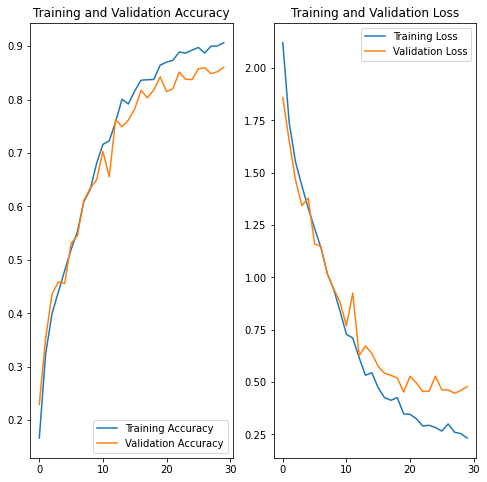

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, Class rebalancing helped here by increasing the aaccuracy and reducing the loss.
Also After adding dropouts, class rebalancing, there is significant decrease between training and validation accuracy, Hence helps in reducing overfitting which means model is able to generalize well.

#### Model4 : Model with Rebalanced data , Dropouts and BatchNormalization

In [75]:
#Batch Normalization


num_classes = 9
model4 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

# keras convolutional layer is called Conv2D, note that the first layer needs to be told the input shape explicitly

model4.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

#flatten and put a fully connected layer
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
# softmax layer
model4.add(Dense(num_classes, activation='softmax'))



In [76]:
# Compile the model
model4.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [77]:
#Train the model
epochs = 30
## Your code goes here, use 30 epochs.
history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 6s 33ms/step - loss: 1.6566 - accuracy: 0.3813 - val_loss: 2.3388 - val_accuracy: 0.2108
Epoch 2/30
169/169 [==============================] - 5s 32ms/step - loss: 1.3014 - accuracy: 0.5054 - val_loss: 3.8128 - val_accuracy: 0.1492
Epoch 3/30
169/169 [==============================] - 5s 32ms/step - loss: 1.0995 - accuracy: 0.5777 - val_loss: 1.8415 - val_accuracy: 0.3920
Epoch 4/30
169/169 [==============================] - 5s 31ms/step - loss: 0.8943 - accuracy: 0.6604 - val_loss: 1.4419 - val_accuracy: 0.4848
Epoch 5/30
169/169 [==============================] - 5s 32ms/step - loss: 0.7077 - accuracy: 0.7357 - val_loss: 2.9003 - val_accuracy: 0.3044
Epoch 6/30
169/169 [==============================] - 5s 32ms/step - loss: 0.6124 - accuracy: 0.7682 - val_loss: 1.1205 - val_accuracy: 0.6325
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 0.4867 - accuracy: 0.8160 - val_loss: 3.0940 - val_accuracy: 0.3415

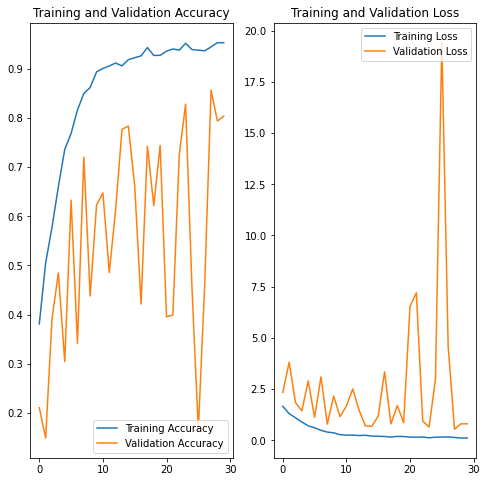

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Details
###### Model 1: Base model

Training Accuracy: around 80%
Validation Accuracy: around 51%
(Overfitting)

###### Model 2: Base model + Augmented data + dropouts

Training Accuracy: around 53%
Validation Accuracy: around 53%
(Underfitting)

###### Model 3: Base model + dropouts + rebalanced data

Training Accuracy: around 90%
Validation Accuracy: around 86%
(Generalized well)

###### Model 4: Basic model + dropouts + rebalanced data + batch normalization 

Training Accuracy: around 95%
Validation Accuracy: around 78%
(overfitting)

Model with Rebalanced data and dropouts performed well w.r.t to training accuracy and validation accuracy. So will use this to make predictions on test data(Model3). 
Model with batch normalization is not consistent and noticed overfitting.Huge spikes are seen so not using this model(Model4)

#### Test Data

In [94]:
#Test data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [95]:
#Just for rescaling the test image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
test_generator  = test_generator.flow_from_directory(data_dir_test,
                                                     target_size=(img_height, img_width),
                                                     batch_size = batch_size,                                                                 
                                                     )                
                                                     

Found 118 images belonging to 9 classes.


In [96]:
#Predicting the probabilities for all the test data
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model3.predict(test_images_ds)
classes_x=np.argmax(probabilities,axis=1)

In [97]:
class_labels=[]
for i in classes_x:
  class_labels.append(class_names[i])

In [98]:
#Check the probability of the class for first image
score = tf.nn.softmax(probabilities[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to squamous cell carcinoma with a 24.94 percent confidence.


In [99]:
probabilities.shape

(118, 9)

In [100]:
# probabilities for each class for first test image
probabilities[0,:]

array([1.2919283e-04, 1.9844890e-02, 5.6105531e-08, 4.3117550e-09,
       2.0502657e-05, 8.9901696e-06, 6.1531748e-13, 9.7999644e-01,
       3.3259484e-09], dtype=float32)

In [86]:
test_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [87]:
file_paths = test_ds.file_paths

In [101]:
#Code to retrieve the image names from filepaths and add them in a list
img_count_test  = len(list(data_dir_test.glob('*/*.jpg')))
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(img_count_test))).numpy().astype('U')

img_list = []
img_id_list = []
img_name_list = []
for i in range(len(file_paths)):
    img_list.append(file_paths[i].split(os.sep)[-1])
    img_id_list.append(i)
    img_name_list.append(file_paths[i].split(os.sep)[-1][0:-4])

img_name_list_by_test_ids = []
for iid in list(test_ids):
    img_name_list_by_test_ids.append(img_name_list[int(iid)])

In [102]:
#Put the image name and class lable in a dataframe
pred_df = pd.DataFrame({'image_name': img_name_list, 'predicted': class_labels})
pred_df

,image_name,predicted
0,ISIC_0024511,squamous cell carcinoma
1,ISIC_0024408,pigmented benign keratosis
2,ISIC_0000035,pigmented benign keratosis
3,ISIC_0024358,nevus
4,ISIC_0024454,nevus
...,...,...
113,ISIC_0011751,squamous cell carcinoma
114,ISIC_0010809,nevus
115,ISIC_0024412,squamous cell carcinoma
116,ISIC_0000003,nevus
